# Load in Data

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os 

pd.options.display.float_format = '{:.6f}'.format


SECONDS_PER_DAY = 60 * 60 * 6.5
raw_messages = pd.read_csv(r'./data/AMZN_2012-06-21_34200000_57600000_message_5.csv', header=None)
raw_book = pd.read_csv(r'./data/AMZN_2012-06-21_34200000_57600000_orderbook_5.csv', header=None)

In [13]:
def clean_lobster(raw_messages, raw_book):

  message_mapping = {0: 'time', 1: 'event', 2: 'id', 3: 'size', 4: 'price', 5: 'dir'}
  book_mapping = { 
                    0: 'ap1', 1: 'as1', 2: 'bp1', 3: 'bs1',
                    4: 'ap2', 5: 'as2', 6: 'bp2', 7: 'bs2',
                    8: 'ap3', 9: 'as3', 10: 'bp3', 11: 'bs3',
                    12: 'ap4', 13: 'as4', 14: 'bp4', 15: 'bs4',
                    16: 'ap5', 17: 'as5', 18: 'bp5', 19: 'bs5'
                  }


  raw_messages.rename(columns=message_mapping, inplace=True)
  raw_book.rename(columns=book_mapping, inplace=True)
  raw_messages.time = raw_messages.time - raw_messages.time[0]
  raw_book.index=raw_messages.time
  raw_messages.set_index('time')
  raw_book.index = pd.to_timedelta(raw_book.index, unit='s')

  raw_book['mid'] = (raw_book.ap1 + raw_book.ap2) / 2


  levels = raw_book.filter(like='p')[['ap5', 'ap4', 'ap3', 'ap2', 'ap1', 'bp1', 'bp2', 'bp3', 'bp4', 'bp5']]
  queues = raw_book.filter(like='s')[['as5', 'as4', 'as3', 'as2', 'as1', 'bs1', 'bs2', 'bs3', 'bs4', 'bs5']]

  levels.columns = levels.columns.str.replace('p', '')
  queues.columns = levels.columns.str.replace('s', '')

  levels.to_csv("./data/levels.csv")
  return levels, queues

levels, queues = clean_lobster(raw_messages, raw_book)

# Determining `dt`

* We need to determine the time interval `dt` for quoting.
* `T` is a single day session.


In [14]:
queue_changes = queues.diff().dropna().astype(bool).sum(axis=0)
level_changes = levels.diff().dropna().astype(bool).sum(axis=0)

changes = pd.DataFrame({'queue changes':queue_changes, "level changes": level_changes})

<AxesSubplot: >

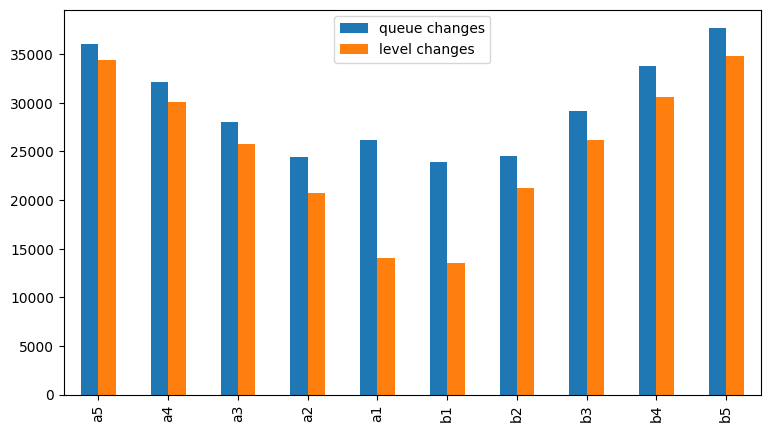

In [15]:
fig, ax = plt.subplots(1, figsize=(9,5))
changes.plot(kind='bar',ax=ax)

<AxesSubplot: ylabel='Frequency'>

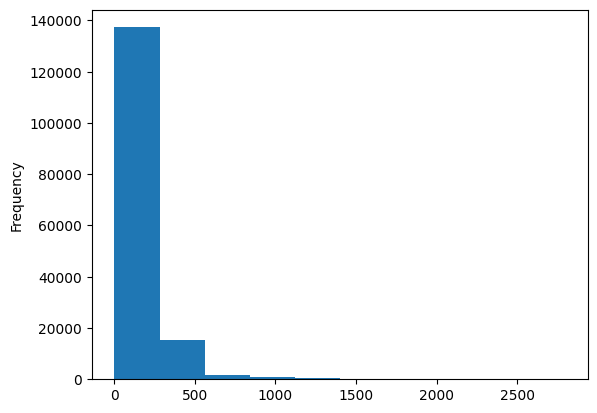

In [16]:
queues.a5.plot(kind='hist')

In [17]:
35000/60/60/6.5

1.495726495726496

We can take means, for example mean number of events, mean number of queue changes over a day, but means are not effective when arrivals are a Poisson process.

In [18]:
print(SECONDS_PER_DAY/raw_messages.id.nunique())
print(SECONDS_PER_DAY/queue_changes.max())
print(SECONDS_PER_DAY/queues.shape[0])

0.2739950587215906
0.6206073465057684
0.15006252605252188


## Analysis

Orderbook arrival rates follow a Poisson process with exponentially distributed interarrival times. This is clear from the two papers I've read (A&S, CST). This implies taking means won't work.

Some candidates for `dt`:

* 0.5s/500ms
* 0.1s/100ms
* 0.01s/1ms

# Calculating Price Series

In [19]:
def resample_prices(ms):

    levels = pd.read_csv('./data/levels.csv',index_col='time', parse_dates=True)
    levels.index = pd.to_timedelta(levels.index)
    levels['mid'] = (levels['a1'] + levels['b1'])/2
    levels = levels.resample(f'{ms}ms').mean().ffill().div(1000)
    logrets = np.log(levels.mid) - np.log(levels.mid.shift(1))
    sigma = logrets.std()

    return levels, levels.mid, sigma

clean_levels, s, sigma = resample_prices(300)

# Calculating A and K: Delta Range

We need to calculate a range of deltas. See Lehalle's [answer](https://quant.stackexchange.com/questions/36073/how-does-one-calibrate-lambda-in-a-avellaneda-stoikov-market-making-problem). Not trivial.

For our delta range, we take the max of the 80th percentile and min of our min.  As a proxy to find our lambdas we difference the midprice then check how long it took for the midpprice to move by threshold `d`. This simulates how long an order has to wait to get filled at distance $\Delta P$ from midprice.

In [20]:
def find_marked_time_deltas(arr, d):
    
    running_sum = 0
    last_occurrence_time = None
    elapsed_times = []
    
    for time_delta, value in arr.iteritems():
        running_sum += value 
    
        if abs(running_sum) >= abs(d):
    
            if last_occurrence_time is not None:
                elapsed_time = time_delta - last_occurrence_time
                elapsed_times.append(elapsed_time)
    
            last_occurrence_time = time_delta
            running_sum = 0  
    
    elapsed_series = pd.Series(elapsed_times)
    return elapsed_series.describe([0.25,0.5,0.75,0.8,0.85,0.95])


In [21]:

def calculate_lambdas(df):

    # calculate book width: the distance from mid for all order book events 
    dist = clean_levels.sub(df.mid,axis=0).drop('mid', axis=1).abs()
    dist_quartiles = dist.describe([0.25,0.5,0.75,0.8,0.85,0.9,0.95])
    display(dist)
    upper, lower = dist_quartiles.loc['80%'].max(), 0.05

    # difference midprice
    mid_diff = clean_levels.mid.diff().dropna()
    mid_diff = mid_diff[mid_diff !=0]

    # see function
    upper_times = find_marked_time_deltas(mid_diff, upper)
    lower_times = find_marked_time_deltas(mid_diff, lower)
    u_time = upper_times.loc['mean'] 
    l_time = lower_times.loc['mean']

    u_lambda = 1/u_time.total_seconds()
    l_lambda = 1/l_time.total_seconds()

    return dist, dist_quartiles, u_lambda, l_lambda, upper, lower

dist, dist_quartiles, u_lambda, l_lambda, upper, lower = calculate_lambdas(clean_levels)


,a5,a4,a3,a2,a1,b1,b2,b3,b4,b5
time,,,,,,,,,,
0 days 00:00:00,3.915000,1.491667,1.231667,0.945000,0.825000,0.825000,1.848333,3.111667,3.948333,5.115000
0 days 00:00:00.300000,4.930137,3.897260,3.397260,2.930137,1.312329,1.312329,2.224658,2.631507,3.121918,3.808219
0 days 00:00:00.600000,4.433333,3.877778,3.733333,1.588889,0.877778,0.877778,1.622222,2.233333,2.822222,3.500000
0 days 00:00:00.900000,4.433333,3.877778,3.733333,1.588889,0.877778,0.877778,1.622222,2.233333,2.822222,3.500000
0 days 00:00:01.200000,4.407143,3.664286,2.664286,1.950000,1.350000,1.350000,2.250000,3.250000,3.750000,4.650000
...,...,...,...,...,...,...,...,...,...,...
0 days 06:29:58.500000,1.091667,0.941667,0.691667,0.491667,0.391667,0.391667,0.641667,0.833333,0.933333,1.033333
0 days 06:29:58.800000,1.205000,0.965000,0.745000,0.645000,0.545000,0.545000,0.645000,0.745000,0.865000,0.965000
0 days 06:29:59.100000,1.419231,1.165385,1.011538,0.811538,0.311538,0.311538,0.411538,0.596154,0.711538,0.811538


C:\Users\Ryan\AppData\Local\Temp\ipykernel_11468\105265019.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for time_delta, value in arr.iteritems():
C:\Users\Ryan\AppData\Local\Temp\ipykernel_11468\105265019.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for time_delta, value in arr.iteritems():


In [22]:
pd.options.display.float_format = "{:,.3f}".format
dist_quartiles.iloc[2:]

,a5,a4,a3,a2,a1,b1,b2,b3,b4,b5
std,0.648,0.540,0.444,0.363,0.282,0.282,0.396,0.501,0.580,0.671
min,0.450,0.350,0.250,0.150,0.050,0.050,0.150,0.250,0.350,0.450
25%,1.100,0.950,0.800,0.650,0.450,0.450,0.740,0.900,1.050,1.200
50%,1.275,1.143,0.975,0.800,0.600,0.600,0.900,1.050,1.200,1.350
75%,1.492,1.300,1.150,0.994,0.800,0.800,1.044,1.200,1.373,1.550
80%,1.550,1.360,1.200,1.004,0.815,0.815,1.068,1.250,1.450,1.600
85%,1.650,1.450,1.250,1.075,0.850,0.850,1.150,1.325,1.500,1.700
90%,1.790,1.557,1.350,1.150,0.900,0.900,1.225,1.450,1.650,1.850
95%,2.233,1.875,1.600,1.350,1.050,1.050,1.433,1.700,2.000,2.350
max,8.950,7.550,6.650,5.150,3.650,3.650,6.300,7.950,8.850,9.900


<AxesSubplot: title={'center': 'Distances from mid'}>

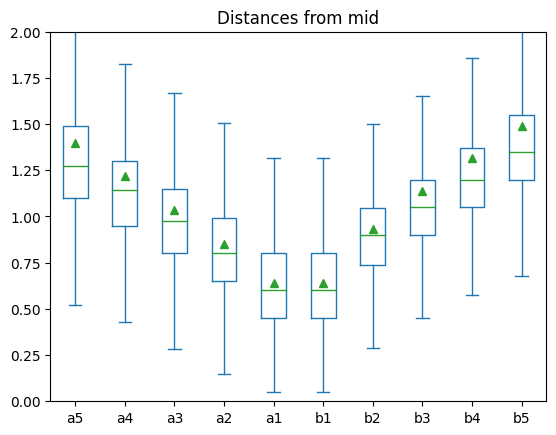

In [23]:
dist.plot(kind='box', ylim=[0,2], showfliers=False, showmeans=True, title='Distances from mid')

In [25]:
clean_levels.to_csv('./data/clean_levels.csv')

Under Poisson assumption, interarrival times (times taken for a fill) is an exponential distribution, $\lambda = 1/E(X)$. We can then calculate using Sophie's formula:

In [26]:
def estimate_a_and_k(u_lambda, l_lambda, upper, lower):
    k = np.log(l_lambda/u_lambda)/(upper - lower)
    A = l_lambda * math.exp(k * lower)
    return A, k

In [27]:
A, k = estimate_a_and_k(u_lambda, l_lambda, upper, lower)

In [29]:
k

2.3055926015811696